 # Leukemia using ATSC

In [199]:
library("binom") 
library("evaluomeR")
library("dplyr")
library("caret")
library("ggplot2")
library("ggrepel")
library("reshape2")
library("mclust")

options(scipen=10)
options(repr.plot.width=12, repr.plot.height=12)

In [200]:
getRversion()
packageVersion("evaluomeR")

[1] '4.4.1'

[1] '1.8.1'

# Dataset <a class="anchor" id="dataset"></a>

In [201]:
seed = 13606
k.range = c(3,10)
cbi = "clara"
alpha = NULL
max_alpha = 0.25 # Default 0.1

In [202]:
load("TCGAData200.RData")
head(TCGAData200)
print(unique(TCGAData200$PAM50))
dataset = TCGAData200
# golub = golub
# colnames(golub)[colnames(golub) == 'Case'] <- 'Description'
# golub$Description <- gsub("AML", "M", golub$Description)
# head(golub)

,Description,PAM50,LTF,NPY1R,PGR,RPS28,SFRP1,PLIN4,S100P,PDZK1,⋯,MMP9,SH3RF2,PADI2,GPAT2,PDE3B,FGFR3,GALNT14,CYP21A2,WISP2,PDE8B
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TCGA-A1-A0SD-01,TCGA-A1-A0SD-01,Luminal A,11.978259,12.778363,9.485349,8.201800,10.709060,10.383206,9.647907,7.358335,⋯,9.400612,6.919838,8.805018,5.132059,6.726067,10.147290,7.240188,8.270969,7.065917,8.211493
TCGA-A1-A0SE-01,TCGA-A1-A0SE-01,Luminal A,12.779078,8.741927,12.807370,3.644445,13.078639,6.667984,5.943417,9.736929,⋯,6.754074,7.920084,10.368784,4.350716,5.254503,9.319850,5.339038,7.419833,8.312402,6.309411
TCGA-A1-A0SH-01,TCGA-A1-A0SH-01,Luminal A,11.231554,5.948533,12.176581,8.229385,11.346664,5.115645,6.905720,2.115633,⋯,9.890979,5.769084,9.537708,6.394867,5.054241,4.145392,4.085272,4.433721,10.229385,7.410264
TCGA-A1-A0SJ-01,TCGA-A1-A0SJ-01,Luminal A,7.804147,9.461259,11.884642,4.163829,10.991285,11.145075,9.916533,8.783936,⋯,9.078549,5.040971,7.239116,6.064818,8.942509,8.637907,6.080500,8.568362,10.756743,6.263365
TCGA-A1-A0SK-01,TCGA-A1-A0SK-01,Basal-like,4.089040,5.483900,2.793584,9.945638,12.763559,1.141498,4.141506,3.463439,⋯,9.403602,2.582074,11.992810,1.656084,8.225936,8.133434,10.766694,1.809250,2.978013,5.154332
TCGA-A1-A0SM-01,TCGA-A1-A0SM-01,Luminal B,7.826276,4.526250,6.455368,9.440371,8.159795,3.336426,11.191101,7.383551,⋯,9.542832,7.889097,9.475339,5.565247,4.762694,6.574833,4.584355,10.308822,9.321558,4.693978


[1] "Luminal A"     "Basal-like"    "Luminal B"     "HER2-enriched"
[5] "Normal-like"  


Three types of classes within the dataset: **B**, **T** and **M**.

In [203]:
level_mapping <- c("Luminal A" = 1, "Basal-like" = 2, "Luminal B" = 3, "HER2-enriched" = 4, "Normal-like" = 5)
map_strings_to_numbers <- function(strings) {
  factorized <- factor(strings, levels = names(level_mapping))
  as.numeric(factorized)
}
gold_standard_vector = as.vector(unlist(lapply(dataset["PAM50"], map_strings_to_numbers)))
gold_standard_vector

[1] 1 1 1 1 2 3 2 1 2 2 3 2 2 1 4 4 1 4 2 1 1 1 3 1 1 3 4 4 1 2 4 2 1 3 1 1 1
 [38] 4 3 1 1 1 1 1 1 3 2 1 3 3 2 1 2 4 2 3 3 1 1 1 1 1 2 1 3 3 1 2 5 1 2 1 2 2
 [75] 1 1 1 3 1 1 2 1 1 2 2 2 3 3 3 3 1 3 3 1 1 3 1 3 4 4 3 4 2 1 1 1 4 1 3 2 1
[112] 2 3 2 3 3 4 3 1 3 3 1 1 4 1 3 3 2 3 4 4 1 3 2 1 4 1 1 1 4 1 4 3 3 3 1 1 1
[149] 3 3 4 3 3 3 3 3 1 1 3 4 3 1 1 1 1 4 3 3 1 1 3 3 1 3 1 4 2 3 3 2 3 2 3 2 1
[186] 3 2 3 2 1 1 1 4 1 2 3 1 2 1 1 1 1 3 1 1 2 1 3 4 1 4 3 3 5 5 5 1 4 3 2 2 3
[223] 1 1 1 5 3 3 4 1 1 3 1 2 3 2 1 1 2 2 1 3 1 4 1 2 1 1 3 2 1 2 3 1 2 3 2 3 1
[260] 4 3 3 2 3 3 2 2 2 2 1 1 1 5 1 2 2 1 4 1 3 1 1 2 2 1 2 1 4 1 3 3 5 1 1 2 4
[297] 3 1 1 1 2 2 1 4 1 3 1 1 1 1 1 4 2 2 1 1 1 3 3 2 1 1 1 2 1 3 1 3 3 2 4 3 3
[334] 1 1 1 1 2 2 1 3 3 4 4 1 1 2 1 1 1 1 3 3 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1
[371] 2 2 3 3 3 3 1 3 3 3 3 3 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 4 4 2 2 1
[408] 1 1 2 1 1 1 1 4 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 3 3 1 4 2
[445] 3 1 1 1 2 3 2 1 1 3 3 2 2 3 3 1 1 1 1 4 4 2 2 4 4 1 1 1 3 3 2 2 2 1 1 1 1
[482] 1 1 1 1 4 4 3 3 2 2 2 4 3 1 1 4 4 4 3 2 3 3 1 4 4 2 1 1 2 4 4 4 4 3 1 3 3
[519] 3 3 4 3 1 2 2 1 2 1 1 3 5 3 3 1 3 1 1 2 3 4 1 2 3 1 4 3 2 2 1 2 4 1 1 1 3
[556] 1 2 2 2 3 3 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 1 1 1 3 3 2 4 1 1 2 1 1 1 1

In [204]:
dataset$Description = TCGAData200$PAM50
dataset_clean = evaluomeR::cleanDataset(dataset, correlation_threshold=1)
pca_suitability = evaluomeR::PCASuitability(dataset_clean$R, sig_level = 0.05)
dataset = dataset_clean$dataset

if (pca_suitability$pca_suitable) {
    r_pca = evaluomeR::performPCA(dataset = dataset)
    dataset = r_pca$dataset_ncp
    evaluomeR::plotPCA_fviz_screeplot(r_pca$pca)
    evaluomeR::plotPCA_fviz_biplot(r_pca$pca)
}
head(dataset)

Preprocessing dataset

Removing non-numeric columns...

	Non-numeric columns found:

		PAM50

Removing correlations...

	No correlated columns found

Checking PCA suitability...

	PCA is not suitable. Bartlett's test p-value: 1



,Description,LTF,NPY1R,PGR,RPS28,SFRP1,PLIN4,S100P,PDZK1,C16orf89,⋯,MMP9,SH3RF2,PADI2,GPAT2,PDE3B,FGFR3,GALNT14,CYP21A2,WISP2,PDE8B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TCGA-A1-A0SD-01,Luminal A,11.978259,12.778363,9.485349,8.201800,10.709060,10.383206,9.647907,7.358335,5.3110271,⋯,9.400612,6.919838,8.805018,5.132059,6.726067,10.147290,7.240188,8.270969,7.065917,8.211493
TCGA-A1-A0SE-01,Luminal A,12.779078,8.741927,12.807370,3.644445,13.078639,6.667984,5.943417,9.736929,5.7540751,⋯,6.754074,7.920084,10.368784,4.350716,5.254503,9.319850,5.339038,7.419833,8.312402,6.309411
TCGA-A1-A0SH-01,Luminal A,11.231554,5.948533,12.176581,8.229385,11.346664,5.115645,6.905720,2.115633,0.8526381,⋯,9.890979,5.769084,9.537708,6.394867,5.054241,4.145392,4.085272,4.433721,10.229385,7.410264
TCGA-A1-A0SJ-01,Luminal A,7.804147,9.461259,11.884642,4.163829,10.991285,11.145075,9.916533,8.783936,5.8437402,⋯,9.078549,5.040971,7.239116,6.064818,8.942509,8.637907,6.080500,8.568362,10.756743,6.263365
TCGA-A1-A0SK-01,Basal-like,4.089040,5.483900,2.793584,9.945638,12.763559,1.141498,4.141506,3.463439,4.4634328,⋯,9.403602,2.582074,11.992810,1.656084,8.225936,8.133434,10.766694,1.809250,2.978013,5.154332
TCGA-A1-A0SM-01,Luminal B,7.826276,4.526250,6.455368,9.440371,8.159795,3.336426,11.191101,7.383551,1.5063480,⋯,9.542832,7.889097,9.475339,5.565247,4.762694,6.574833,4.584355,10.308822,9.321558,4.693978


# evaluomeR - (ATSC) optimal $k$ analysis <a class="anchor" id="evaluomeR"></a>

In this Section, evaluomeR executes an optimal $k$ analysis. First, stabilities and qualities are calculated, considering all the metrics in the dataset. The $k$ range is $k \in [3,10]$ and the clustering method is `clara`.

In [205]:
r_atsc = evaluomeR::ATSC(data=dataset, k.range=k.range, cbi=cbi, alpha=alpha, 
                         max_alpha=max_alpha, gold_standard=gold_standard_vector, seed=seed)

Computing optimal k value with 'clara'




Data loaded.
Number of rows: 591
Number of columns: 201



Processing all metrics, 'merge', in dataframe (200)

	Calculation of k = 3

	Calculation of k = 4

	Calculation of k = 5

	Calculation of k = 6

	Calculation of k = 7

	Calculation of k = 8

	Calculation of k = 9

	Calculation of k = 10



Data loaded.
Number of rows: 591
Number of columns: 201



Processing all metrics, 'merge', in dataframe (200)

	Calculation of k = 3

	Calculation of k = 4

	Calculation of k = 5

	Calculation of k = 6

	Calculation of k = 7

	Calculation of k = 8

	Calculation of k = 9

	Calculation of k = 10

Processing metric: all_metrics


	Both Ks do not have a stable classification: '6', '3'


	Using '3' since it provides higher silhouette width


Optimal k: 3

Determining best L1 and alpha parameter automatically, it might take a while...

Computing best L1 boundry with 'sparcl::KMeansSparseCluster.permute'

Best L1 found is: 11.6299696326142

	Using L1 '11.6

In [206]:
print(paste0("ATSC Optimal k: ", r_atsc$optimalK_ATSC))
print(paste0("Best L1 boundry found: ", r_atsc$L1))
print(paste0("Best alpha found: ", r_atsc$alpha))
if (!is.null(r_atsc$gold_standard_trimmed)) {
    print(paste0("Gold standard vector trimmed, current values are:"))
    print(gold_standard_vector)
    print("After:")
    print(r_atsc$gold_standard_trimmed)
    gold_standard_vector = r_atsc$gold_standard_trimmed
}

[1] "ATSC Optimal k: 3"
[1] "Best L1 boundry found: 11.6299696326142"
[1] "Best alpha found: 0.05"
[1] "Gold standard vector trimmed, current values are:"
  [1] 1 1 1 1 2 3 2 1 2 2 3 2 2 1 4 4 1 4 2 1 1 1 3 1 1 3 4 4 1 2 4 2 1 3 1 1 1
 [38] 4 3 1 1 1 1 1 1 3 2 1 3 3 2 1 2 4 2 3 3 1 1 1 1 1 2 1 3 3 1 2 5 1 2 1 2 2
 [75] 1 1 1 3 1 1 2 1 1 2 2 2 3 3 3 3 1 3 3 1 1 3 1 3 4 4 3 4 2 1 1 1 4 1 3 2 1
[112] 2 3 2 3 3 4 3 1 3 3 1 1 4 1 3 3 2 3 4 4 1 3 2 1 4 1 1 1 4 1 4 3 3 3 1 1 1
[149] 3 3 4 3 3 3 3 3 1 1 3 4 3 1 1 1 1 4 3 3 1 1 3 3 1 3 1 4 2 3 3 2 3 2 3 2 1
[186] 3 2 3 2 1 1 1 4 1 2 3 1 2 1 1 1 1 3 1 1 2 1 3 4 1 4 3 3 5 5 5 1 4 3 2 2 3
[223] 1 1 1 5 3 3 4 1 1 3 1 2 3 2 1 1 2 2 1 3 1 4 1 2 1 1 3 2 1 2 3 1 2 3 2 3 1
[260] 4 3 3 2 3 3 2 2 2 2 1 1 1 5 1 2 2 1 4 1 3 1 1 2 2 1 2 1 4 1 3 3 5 1 1 2 4
[297] 3 1 1 1 2 2 1 4 1 3 1 1 1 1 1 4 2 2 1 1 1 3 3 2 1 1 1 2 1 3 1 3 3 2 4 3 3
[334] 1 1 1 1 2 2 1 3 3 4 4 1 1 2 1 1 1 1 3 3 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1
[371] 2 2 3 3 3 3 1 3 3 3 3 3 1 1 1 1 1 1 1 1

## Stability plotting <a class="anchor" id="evaluomeR_stab_plot"></a>

Stability plot

In [207]:
stab = r_atsc$stab
rownames(stab) = c(paste0("stab_", cbi))
stab$Metric = rownames(stab)
stab$Method = "without ATSC"
stab_melt = melt(stab, id.vars = c("Metric", "Method"))

stab_ATSC = r_atsc$stab_ATSC
rownames(stab_ATSC) = c(paste0("stab_", "ATSC"))
stab_ATSC$Metric = rownames(stab_ATSC)
stab_ATSC$Method = "with ATSC"
stab_ATSC_melt = melt(stab_ATSC, id.vars = c("Metric", "Method"))

In [208]:
stab_ATSC

,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10,Metric,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
stab_ATSC,0.6457319,0.7243926,0.7341964,0.7257584,0.7031886,0.6932438,0.7048685,0.7236424,stab_ATSC,with ATSC


In [209]:
library(scales)

# This method makes the range [0,0.6], [0.6,0.75], [0.75, 0.85], [0.85,1] the same size in the Y axis
equal_parts_transformation_stability <- trans_new(
    name = "equal_parts",
    transform = function(x) {
        ifelse(x <= 0.6, x / 0.6 * 0.25, # Map 0-0.6 to 0-0.25
               ifelse(x <= 0.75, 0.25 + (x - 0.6) / 0.15 * 0.25, # Map 0.6-0.75 to 0.25-0.5
                      ifelse(x <= 0.85, 0.5 + (x - 0.75) / 0.1 * 0.25, # Map 0.75-0.85 to 0.5-0.75
                             0.75 + (x - 0.85) / 0.15 * 0.25))) # Map 0.85-1 to 0.75-1
    },
    inverse = function(y) {
        ifelse(y <= 0.25, y * 0.6 / 0.25, # Map 0-0.25 back to 0-0.6
               ifelse(y <= 0.5, 0.6 + (y - 0.25) * 0.15 / 0.25, # Map 0.25-0.5 back to 0.6-0.75
                      ifelse(y <= 0.75, 0.75 + (y - 0.5) * 0.1 / 0.25, # Map 0.5-0.75 back to 0.75-0.85
                             0.85 + (y - 0.75) * 0.15 / 0.25))) # Map 0.75-1 back to 0.85-1
    }
)

# This method makes the range [-1,0.25], [0.25,0.5], [0.5,0.7],[0.7,1] the same size in the Y axis
equal_parts_transformation_quality <- trans_new(
    name = "equal_parts",
    transform = function(x) {
        ifelse(x <= 0.25, (x + 1) / 1.25 * 0.25, # Map [-1, 0.25] to [0, 0.25]
               ifelse(x <= 0.5, 0.25 + (x - 0.25) / 0.25 * 0.25, # Map [0.25, 0.5] to [0.25, 0.5]
                      ifelse(x <= 0.7, 0.5 + (x - 0.5) / 0.2 * 0.25, # Map [0.5, 0.7] to [0.5, 0.75]
                             0.75 + (x - 0.7) / 0.3 * 0.25))) # Map [0.7, 1] to [0.75, 1]
    },
    inverse = function(y) {
        ifelse(y <= 0.25, y * 1.25 - 1, # Map [0, 0.25] back to [-1, 0.25]
               ifelse(y <= 0.5, 0.25 + (y - 0.25) * 0.25, # Map [0.25, 0.5] back to [0.25, 0.5]
                      ifelse(y <= 0.75, 0.5 + (y - 0.5) * 0.2, # Map [0.5, 0.75] back to [0.5, 0.7]
                             0.7 + (y - 0.75) * 0.3))) # Map [0.75, 1] back to [0.7, 1]
    }
)

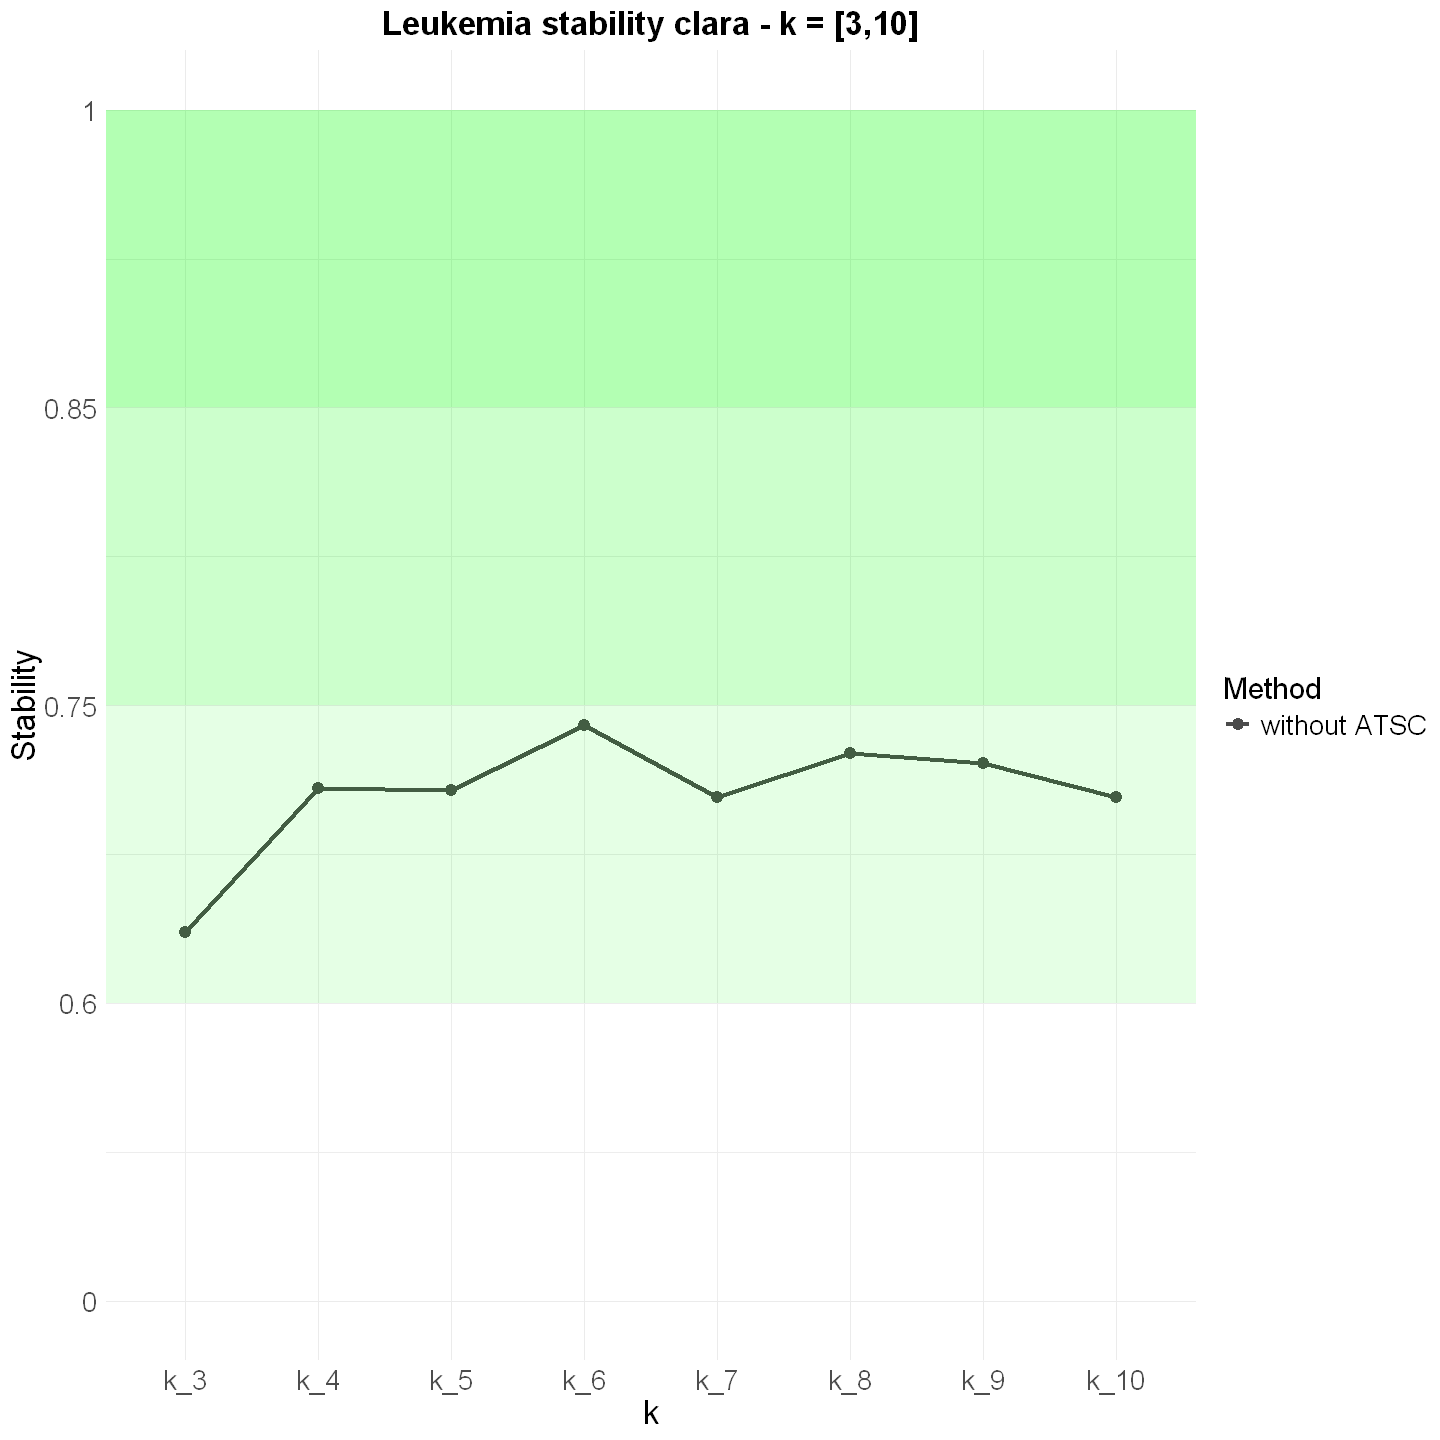

In [210]:
colors <- c("#4B4B4B", "#1E90FF", "black", "darkgray", "gray", "lightgray", "white")


p <- ggplot(stab_melt, aes(x = variable, y = value, color = Method, group = Method)) +
    geom_point(size = 3) +
    geom_line(size = 1.2) +
    scale_color_manual(values = colors) +
    labs(
        title = paste0('Leukemia stability ', cbi, ' - k = [', k.range[1], ",", k.range[2], ']'),
        x = 'k',
        y = 'Stability'
    ) +
    scale_y_continuous(
        trans = equal_parts_transformation_stability,
        breaks = c(0, 0.6, 0.75, 0.85, 1),
        labels = c("0", "0.6", "0.75", "0.85", "1")
    ) +
    theme_minimal() +
    theme(
        plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
        legend.position = "right",
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 16),
        axis.title.x = element_text(size = 20),
        axis.title.y = element_text(size = 20),
        axis.text = element_text(size = 16)
    )

p + 
    annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.3, fill = "green") +
    annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.2, fill = "green") +
    annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.1, fill = "green") +
    annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.1, fill = "white")


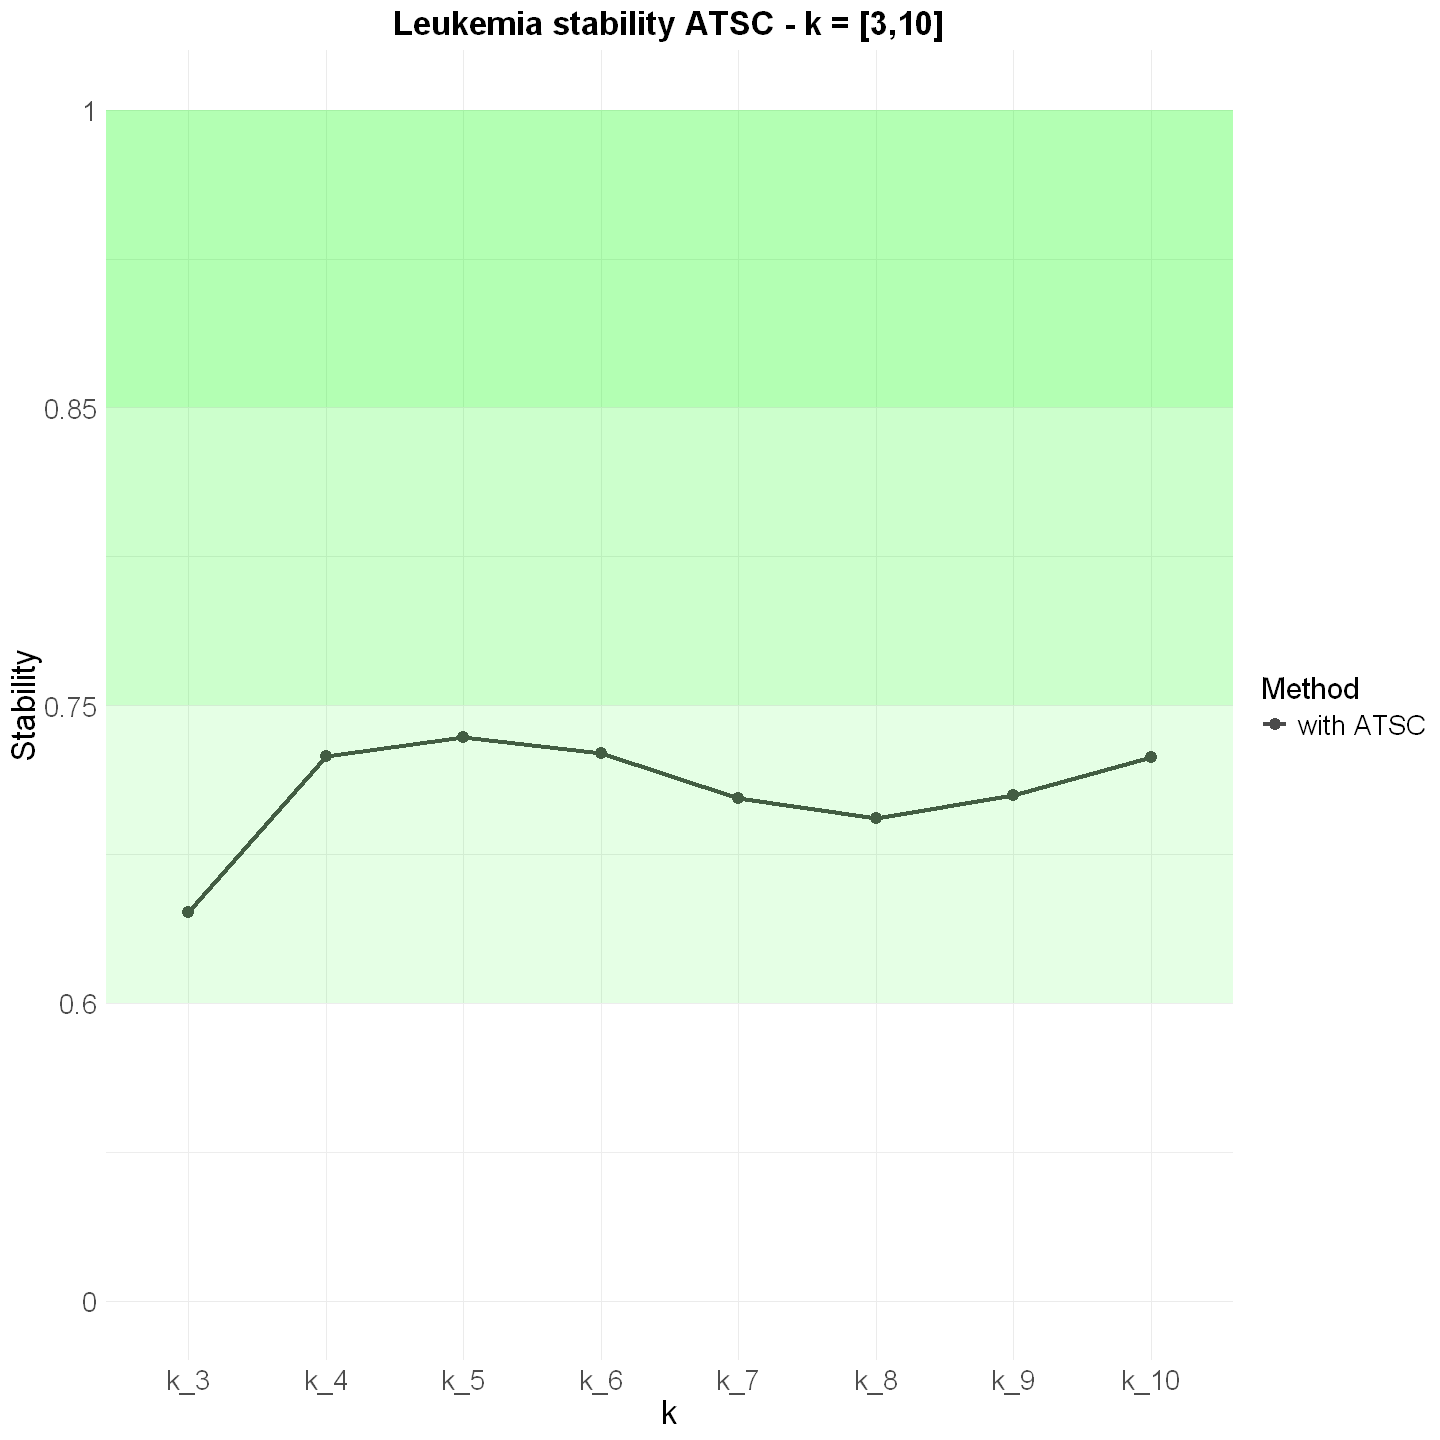

In [211]:
# Stab ATSC
p <- ggplot(stab_ATSC_melt, aes(x = variable, y = value, color = Method, group = Method)) +
    geom_point(size = 3) +
     geom_line(size = 1.2) +
  scale_color_manual(values = colors) +
  labs(
    title = paste0('Leukemia stability ATSC - k = [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Stability'
  ) +
  scale_y_continuous(
        trans = equal_parts_transformation_stability,
        breaks = c(0, 0.6, 0.75, 0.85, 1),
        labels = c("0", "0.6", "0.75", "0.85", "1")
    ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16)
  )

p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.3, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.2, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.1, fill = "white")

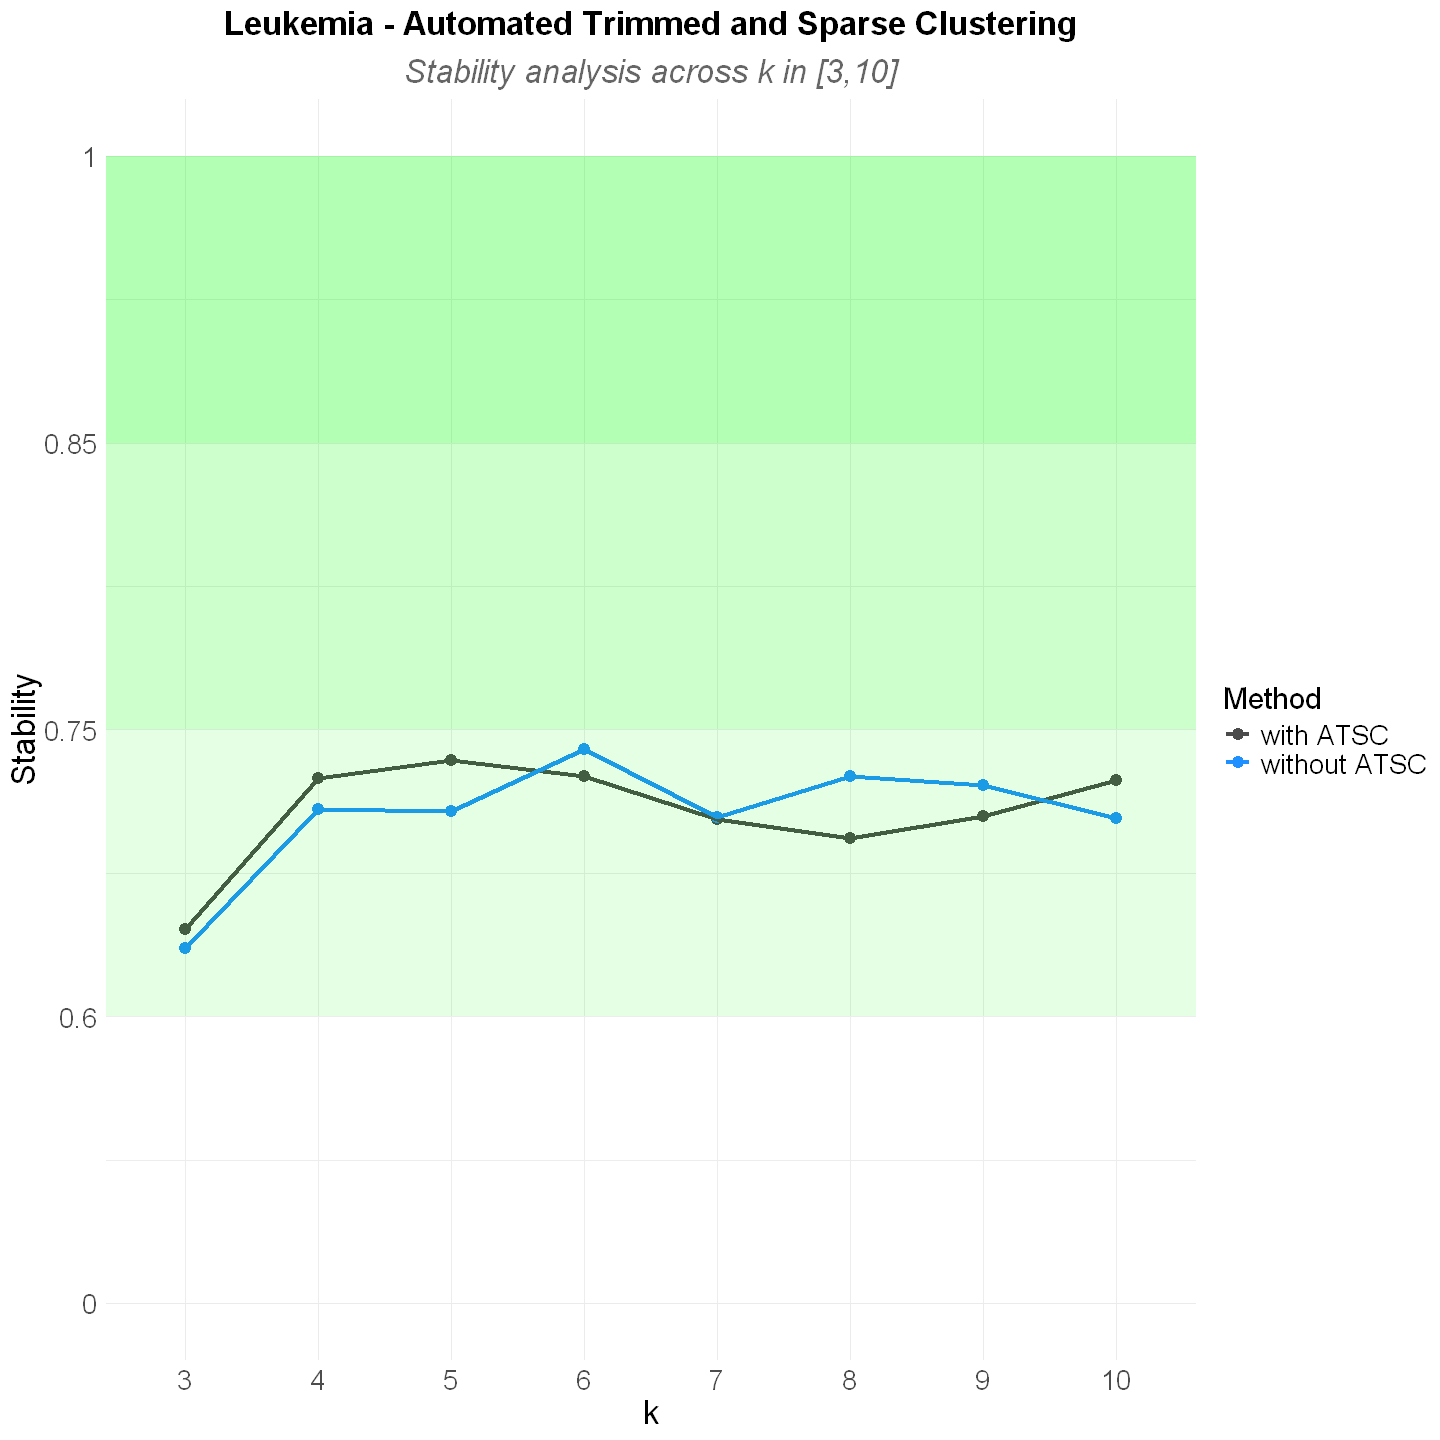

In [212]:
all_stab = rbind(stab_ATSC_melt, stab_melt)
p <- ggplot(all_stab, aes(x = variable, y = value, color = Method, group = Method)) +
    geom_point(size = 3) +
     geom_line(size = 1.2) +
  scale_color_manual(values = colors) +
  labs(
    title = expression(bold("Leukemia - Automated Trimmed and Sparse Clustering")),
    subtitle = "Stability analysis across k in [3,10]",
    x = 'k',
    y = 'Stability'
  ) +
  scale_y_continuous(
        trans = equal_parts_transformation_stability,
        breaks = c(0, 0.6, 0.75, 0.85, 1),
        labels = c("0", "0.6", "0.75", "0.85", "1")
    ) +
  scale_x_discrete(labels = function(x) sub("k_", "", x)) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 20, face = "italic", color = "gray40"),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16)
  )

p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.3, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.2, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.1, fill = "white")

## Quality plotting <a class="anchor" id="evaluomeR_qual_plot"></a>

Quality plot

In [213]:
qual = r_atsc$qual
rownames(qual) = c(paste0("qual_", cbi))
qual$Metric = rownames(qual)
qual$Method = "without ATSC"
qual_melt = melt(qual, id.vars = c("Metric", "Method"))

qual_ATSC = r_atsc$qual_ATSC
rownames(qual_ATSC) = c(paste0("qual_", "ATSC"))
qual_ATSC$Metric = rownames(qual_ATSC)
qual_ATSC$Method = "with ATSC"
qual_ATSC_melt = melt(qual_ATSC, id.vars = c("Metric", "Method"))

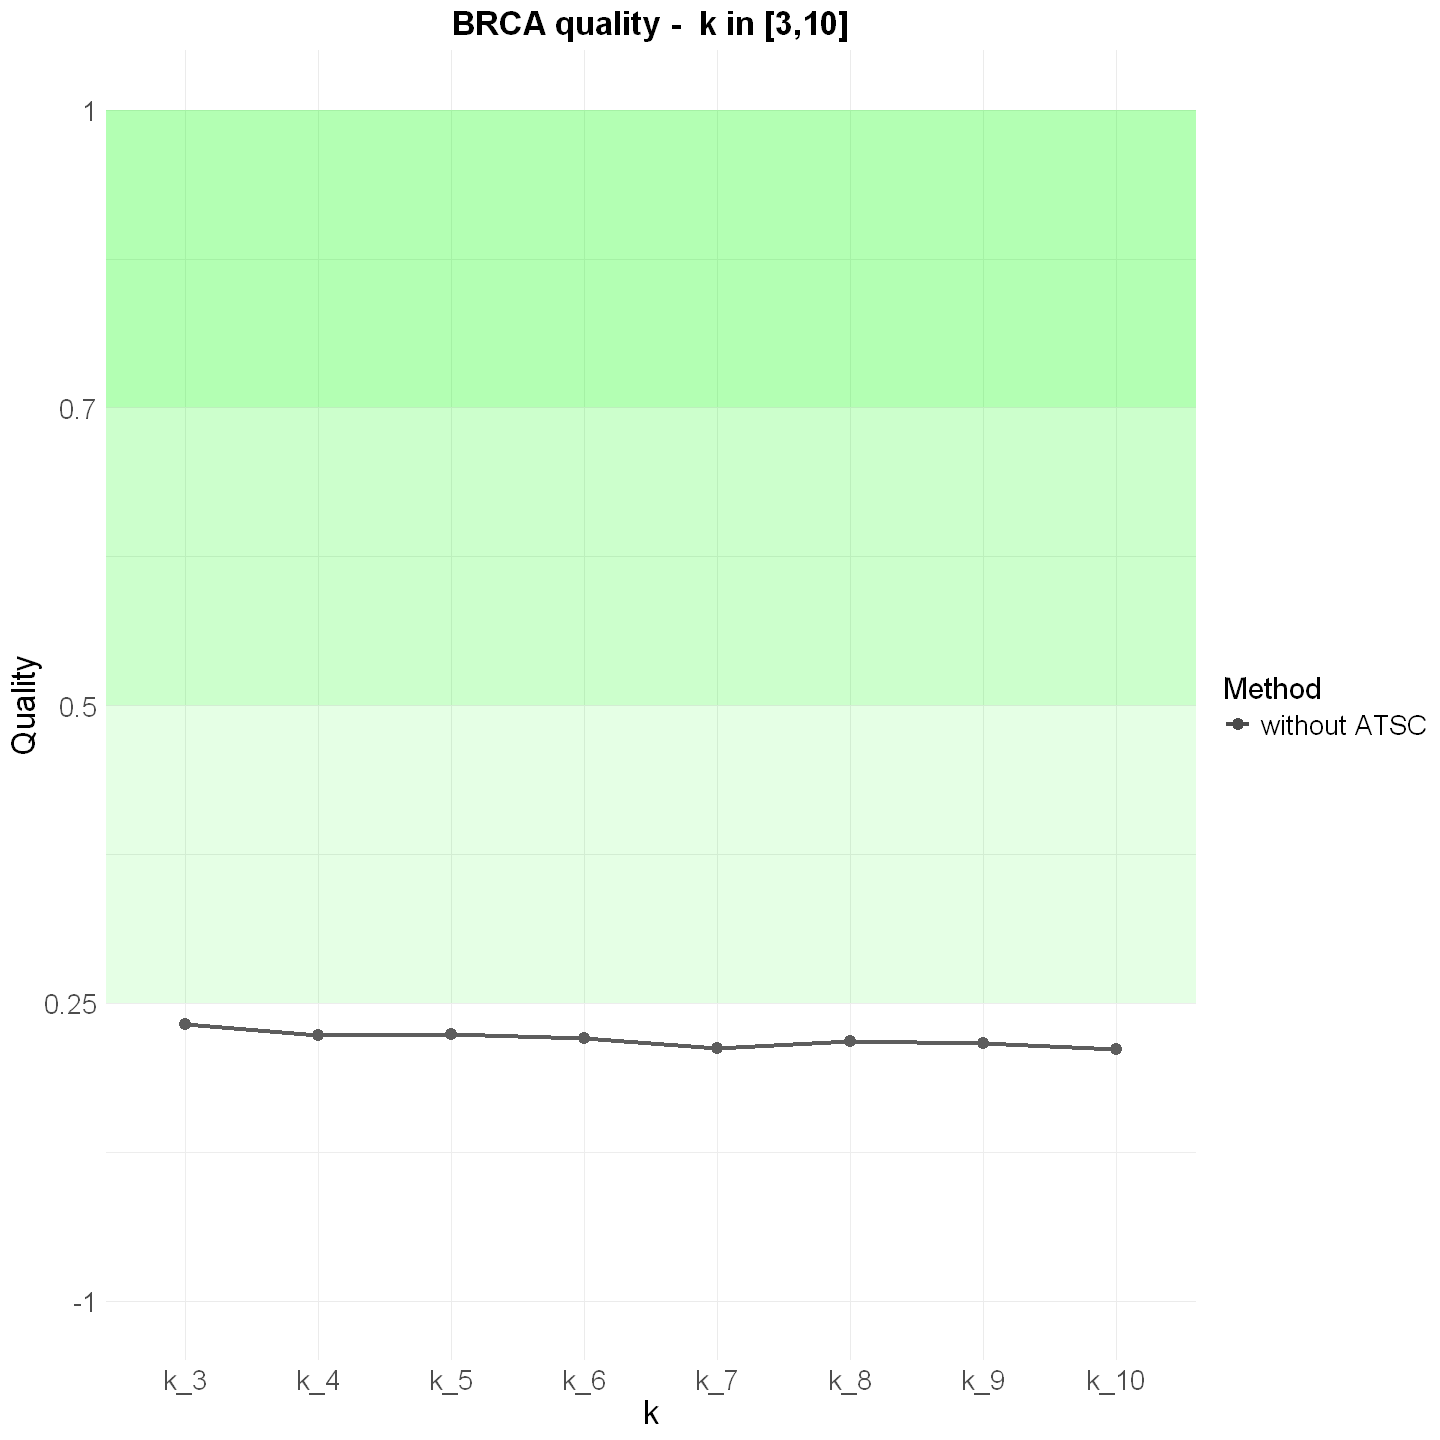

In [214]:
p <- ggplot(qual_melt, aes(x = variable, y = value, color = Method, group = Method)) +
     geom_point(size = 3) +
     geom_line(size = 1.2) +
  scale_color_manual(values = colors) +
  labs(
    title = paste0('BRCA quality -  k in [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Quality'
  ) +
  scale_y_continuous(
        trans = equal_parts_transformation_quality,
        breaks = c(-1, 0.25, 0.5, 0.7, 1),
        labels = c("-1", "0.25", "0.5", "0.7", "1")
    ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16)
  )

p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.7, ymax = 1, alpha = 0.3, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.5, ymax = 0.7, alpha = 0.2, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.25, ymax = 0.5, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = -1, ymax = 0.25, alpha = 0.1, fill = "white")

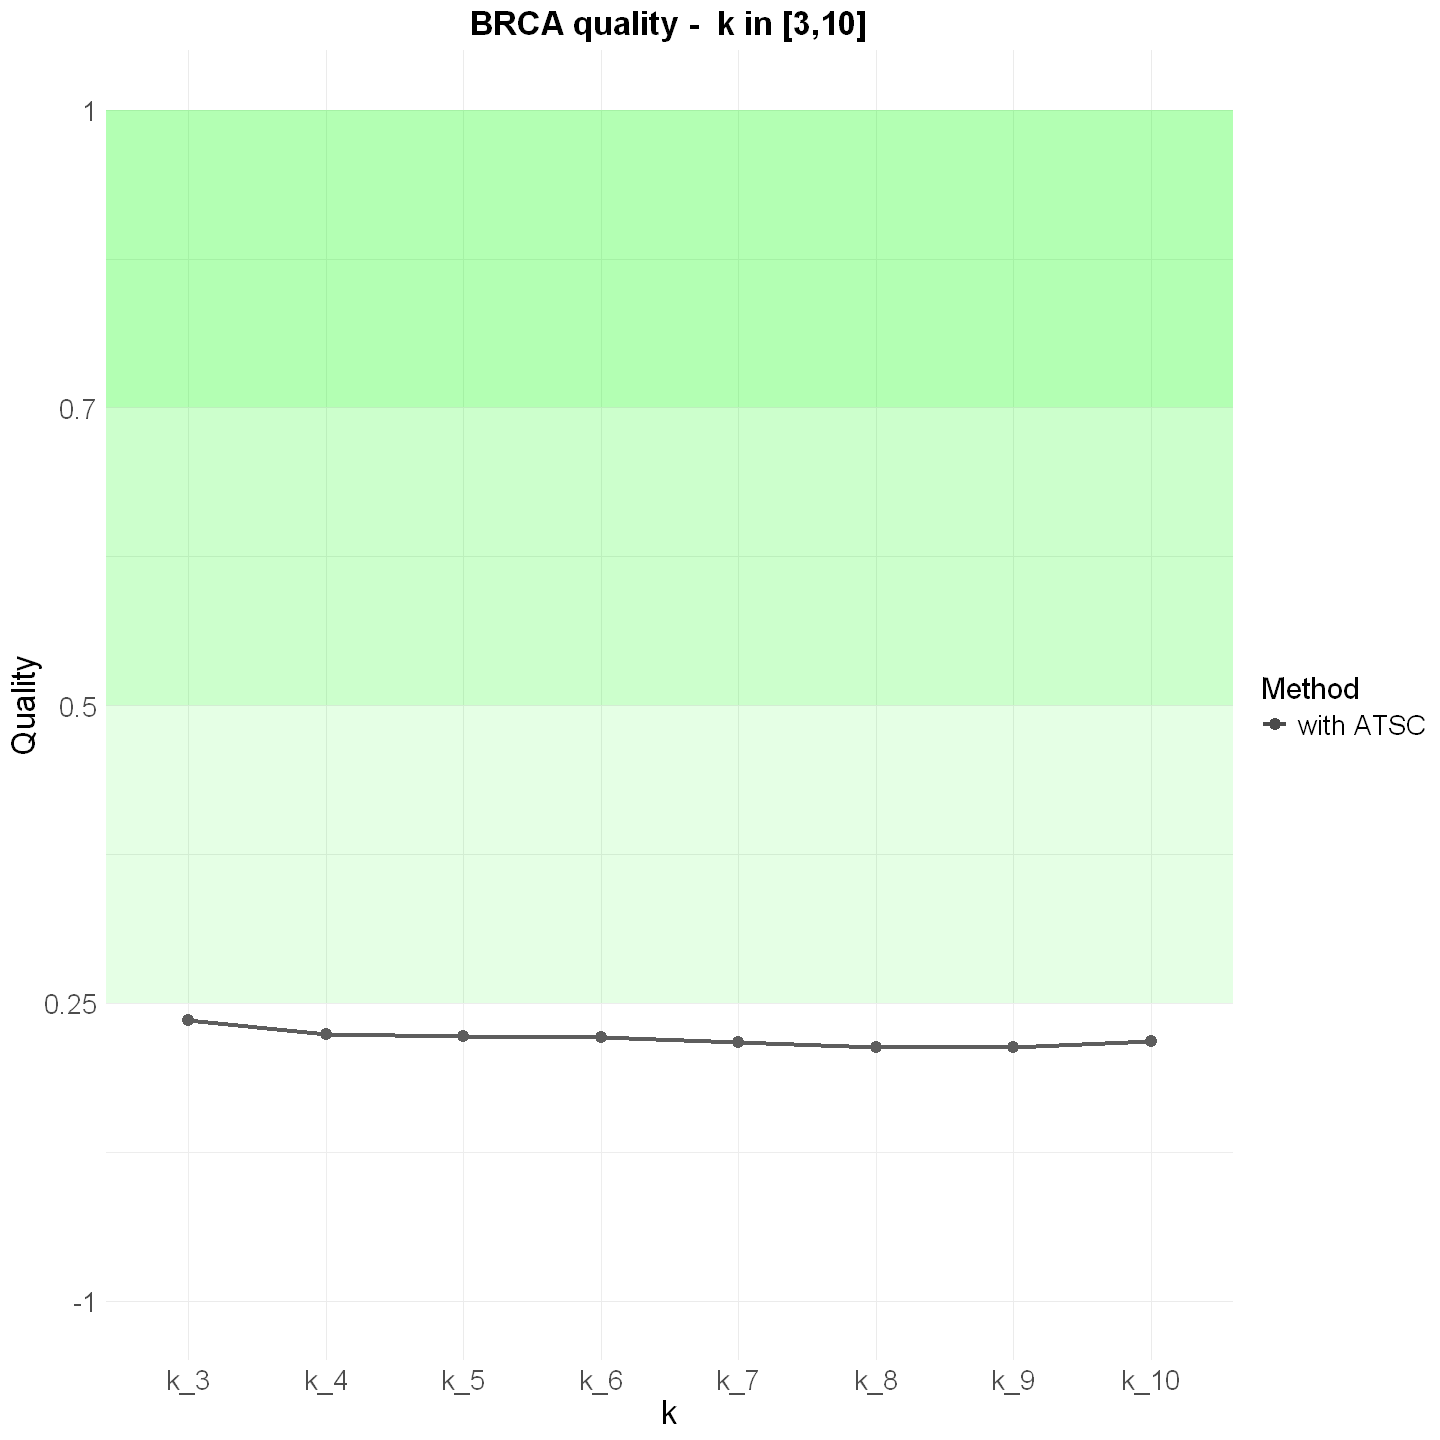

In [215]:
p <- ggplot(qual_ATSC_melt, aes(x = variable, y = value, color = Method, group = Method)) +
     geom_point(size = 3) +
     geom_line(size = 1.2) +
  scale_color_manual(values = colors) +
  labs(
    title = paste0('BRCA quality -  k in [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Quality'
  ) +
  scale_y_continuous(
        trans = equal_parts_transformation_quality,
        breaks = c(-1, 0.25, 0.5, 0.7, 1),
        labels = c("-1", "0.25", "0.5", "0.7", "1")
    ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16)
  )

p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.7, ymax = 1, alpha = 0.3, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.5, ymax = 0.7, alpha = 0.2, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.25, ymax = 0.5, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = -1, ymax = 0.25, alpha = 0.1, fill = "white")

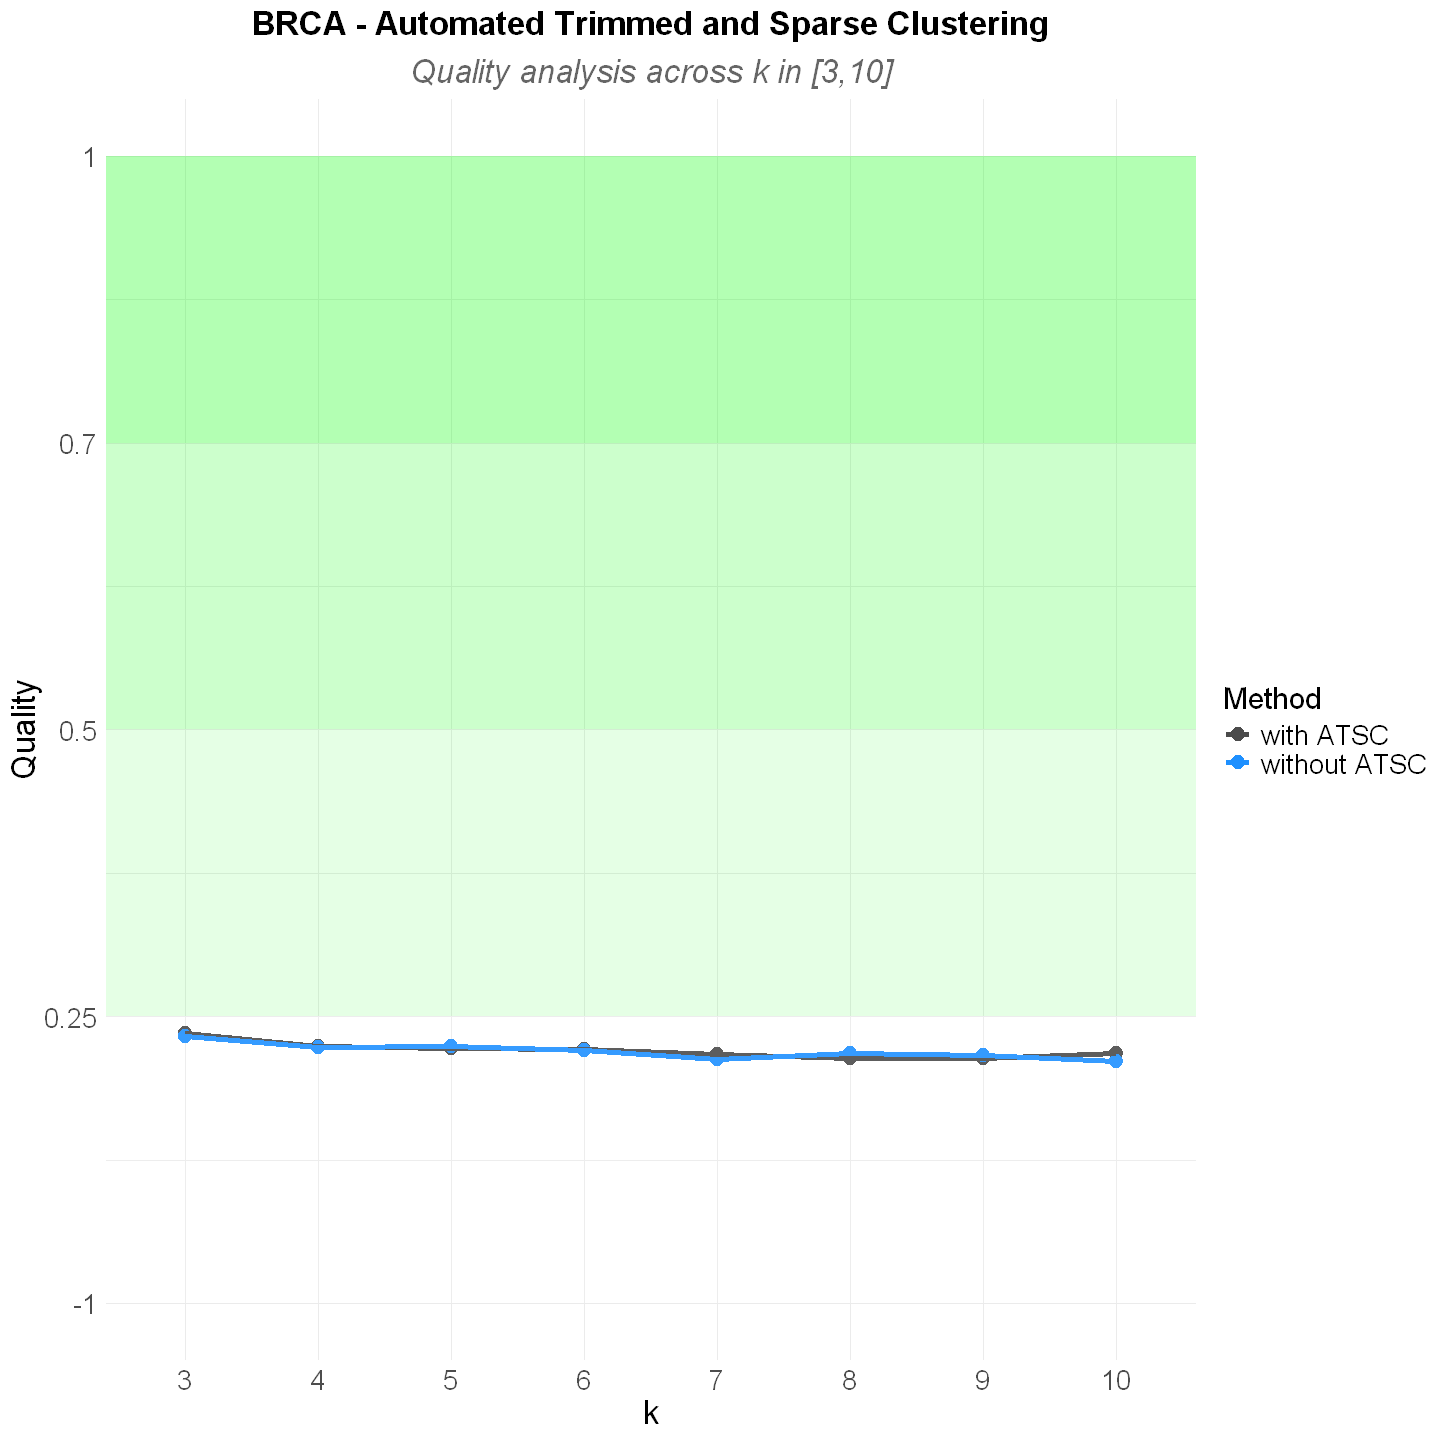

In [216]:
all_qual = rbind(qual_ATSC_melt, qual_melt)
p <- ggplot(all_qual, aes(x = variable, y = value, color = Method, group = Method)) +
     geom_point(size = 3.5) +
     geom_line(size = 1.5) +
  scale_color_manual(values = colors) +
  labs(
    title = expression(bold("BRCA - Automated Trimmed and Sparse Clustering")),
    subtitle = "Quality analysis across k in [3,10]",
    x = 'k',
    y = 'Quality'
  ) +
  scale_y_continuous(
        trans = equal_parts_transformation_quality,
        breaks = c(-1, 0.25, 0.5, 0.7, 1),
        labels = c("-1", "0.25", "0.5", "0.7", "1")
    ) +
  scale_x_discrete(labels = function(x) sub("k_", "", x)) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 20, face = "italic", color = "gray40"),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16)
  )

p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.7, ymax = 1, alpha = 0.3, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.5, ymax = 0.7, alpha = 0.2, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.25, ymax = 0.5, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = -1, ymax = 0.25, alpha = 0.1, fill = "white")

Determining the optimal $k$ given the stabilities and qualities in `stab_range` and `qual_range` objects:

In [217]:
print(paste0("Stabilities and qualities per k with '", cbi, "' as clustering method"))
stab
qual
print(paste0("Stabily in k=", r_atsc$optimalK,": ", stab[paste0("k_",r_atsc$optimalK)]))
print(paste0("Quality in k=", r_atsc$optimalK,": ", qual[paste0("k_",r_atsc$optimalK)]))

[1] "Stabilities and qualities per k with 'clara' as clustering method"


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10,Metric,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
stab_clara,0.6357854,0.7085205,0.7073618,0.7398319,0.7039147,0.7257793,0.7206745,0.7036164,stab_clara,without ATSC


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10,Metric,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
qual_clara,0.1627422,0.1169256,0.1199871,0.1042103,0.06148168,0.09064039,0.08178437,0.05555532,qual_clara,without ATSC


[1] "Stabily in k=3: 0.635785368092001"
[1] "Quality in k=3: 0.162742188969456"


In [218]:
print(paste0("Stabilities and qualities per k with 'ATSC' as clustering method"))
stab_ATSC
qual_ATSC
print(paste0("Stabily in k=", r_atsc$optimalK_ATSC,": ", stab_ATSC[paste0("k_",r_atsc$optimalK_ATSC)]))
print(paste0("Quality in k=", r_atsc$optimalK_ATSC,": ", qual_ATSC[paste0("k_",r_atsc$optimalK_ATSC)]))

[1] "Stabilities and qualities per k with 'ATSC' as clustering method"


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10,Metric,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
stab_ATSC,0.6457319,0.7243926,0.7341964,0.7257584,0.7031886,0.6932438,0.7048685,0.7236424,stab_ATSC,with ATSC


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10,Metric,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
qual_ATSC,0.1774306,0.121517,0.1126261,0.1064051,0.08577924,0.06574794,0.06642075,0.08966928,qual_ATSC,with ATSC


[1] "Stabily in k=3: 0.645731945806965"
[1] "Quality in k=3: 0.177430605197991"


# Clusters

In [219]:
# Internal method used to group individuals per cluster
individuals_per_cluster = function(qualityResult) {
    
  qual_df = as.data.frame(assay(qualityResult))
    

  cluster_pos_str = as.character(unlist(qual_df["Cluster_position"]))
  cluster_labels_str = as.character(unlist(qual_df["Cluster_labels"]))

  cluster_pos = as.list(strsplit(cluster_pos_str, ",")[[1]])
  cluster_labels = as.list(strsplit(cluster_labels_str, ",")[[1]])

  individuals_in_cluster = as.data.frame(cbind(cluster_labels, cluster_pos))
  colnames(individuals_in_cluster) = c("Individual", "Cluster")

  return(individuals_in_cluster)
}

In [220]:
dataset = r_atsc$trimmmedDataset
qual_range = qualityRange(data=dataset, k.range=k.range, 
                            all_metrics=TRUE, seed=seed,
                            cbi=cbi)
optimal_k = r_atsc$optimalK_ATSC
cluster_individuals = individuals_per_cluster(assay(qual_range[paste0("k_",optimal_k)]))
print(paste0("CBI: ", cbi, " - k: ", optimal_k))
for (cluster_i in 1:optimal_k) {
    ind_in_cluster = paste(unlist(cluster_individuals[cluster_individuals$Cluster == cluster_i, ]["Individual"]), collapse = ",")
    print(paste("Cluster", cluster_i, ":", ind_in_cluster))
    print("")
}



Data loaded.
Number of rows: 559
Number of columns: 201



Processing all metrics, 'merge', in dataframe (200)

	Calculation of k = 3

	Calculation of k = 4

	Calculation of k = 5

	Calculation of k = 6

	Calculation of k = 7

	Calculation of k = 8

	Calculation of k = 9

	Calculation of k = 10



[1] "CBI: clara - k: 3"
[1] "Cluster 1 : Luminal A,Luminal A,Luminal A,Luminal A,Luminal B,Luminal A,Luminal B,Luminal A,HER2-enriched,Luminal A,Luminal A,Luminal A,Luminal A,Luminal B,Luminal A,Luminal A,Luminal B,HER2-enriched,HER2-enriched,Luminal A,Luminal A,Luminal B,Luminal A,Luminal A,Luminal A,Luminal B,Luminal A,Luminal A,Luminal A,Luminal B,Luminal A,Luminal B,Luminal B,Luminal A,Luminal B,Luminal B,Luminal A,Luminal A,Luminal A,Luminal A,Luminal A,Luminal A,Luminal B,Luminal B,Luminal A,Luminal A,Luminal A,Luminal A,Luminal A,Luminal B,Luminal A,Luminal A,Luminal B,Luminal B,Luminal A,Luminal B,Luminal B,Luminal A,Luminal A,Luminal B,Luminal A,Luminal B,HER2-enriched,HER2-enriched,Luminal B,HER2-enriched,Luminal A,Luminal A,Luminal A,HER2-enriched,Luminal A,Luminal B,Luminal A,Luminal B,Luminal B,Luminal B,HER2-enriched,Luminal B,Luminal A,Luminal B,Luminal A,Luminal A,HER2-enriched,Luminal A,Luminal B,Luminal B,Luminal B,HER2-enriched,Luminal A,Luminal B,Luminal A,Luminal A

# PCA <a class="anchor" id="pca"></a>
We employ Principal Component Analysis (PCA) as a dimensionality reduction technique to facilitate the visualization of clusters within our dataset. PCA allow us to transform the original high-dimensional data into a lower-dimensional space, while preserving as much of the variability as possible.

In [221]:
dataset["Cluster"] = as.factor(as.numeric(cluster_individuals$Cluster))
if (pca_suitability$pca_suitable) {
    pca_df = dataset
} else {
    pca_matrix = dataset %>% select(-Cluster)
    r_pca = evaluomeR::performPCA(dataset = pca_matrix)
    pca_df = r_pca$dataset_ncp
    pca_df$Cluster <- as.factor(dataset$Cluster)
    pca_df$Description <- dataset$Description
}
head(pca_df)

Parameter 'npc' is null. Computing number of factors automatically:

Number of factors, 'ncp' used is: 33



,Description,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,Dim.6,Dim.7,Dim.8,Dim.9,⋯,Dim.25,Dim.26,Dim.27,Dim.28,Dim.29,Dim.30,Dim.31,Dim.32,Dim.33,Cluster
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
TCGA-A1-A0SD-01,Luminal A,5.1243467,2.5076399,1.95999749,0.1437765,2.3816193,0.5204328,2.21942619,-1.612192,2.6950711,⋯,0.9768887,-0.3709164,0.2381918,-1.69469233,0.7714238,0.12393540,0.01467181,-0.70521470,1.2998475,1
TCGA-A1-A0SE-01,Luminal A,4.9785589,2.7381656,-0.64945886,3.2115378,2.5420756,0.5997728,1.85718158,-1.264566,-1.5343599,⋯,-0.3620061,-0.4067026,0.7480189,-0.37218519,-1.4197829,-0.87476980,-1.10693316,0.11138522,-1.4489428,1
TCGA-A1-A0SH-01,Luminal A,0.2936514,-0.4503151,1.05687099,4.8858944,0.9739034,4.0886458,-0.70382984,-2.916300,0.4312341,⋯,-0.5351298,0.2254946,0.1088299,-0.07991772,-0.4640188,-1.07359848,0.14105257,-1.24281584,-0.9173950,1
TCGA-A1-A0SJ-01,Luminal A,3.8440883,3.3052743,-0.08210286,-3.4383744,2.1740079,2.4105177,0.01577641,2.235772,1.5782149,⋯,0.6002222,-0.1133023,1.5869282,-0.22207697,-1.6647507,0.03883067,-0.02202507,0.02280557,-0.7462445,1
TCGA-A1-A0SK-01,Basal-like,-9.2079947,-4.5625644,-7.30103383,-1.3653058,-0.7351720,3.1721757,1.24178349,-7.445340,-1.4954592,⋯,-2.4729695,0.5761680,1.8311916,0.90394804,1.7382517,2.28252059,-2.20949463,-1.53852753,-1.1606555,2
TCGA-A1-A0SM-01,Luminal B,4.1763504,-3.7990614,0.73361692,3.5172192,-1.7207462,3.7603382,1.61360134,-1.377817,2.3015721,⋯,2.1621825,0.1733006,1.8797904,-0.71082769,-1.9339189,-0.50576101,0.39001272,-1.43623992,0.2582947,1


In [222]:
# Creating shapes for individuals
pca_df <- pca_df %>%
  mutate(
    # Extract the letter from the Description column
    Letter = Description,
    # Map the letter to a number
    GoldStandard = case_when(
      Letter == "Luminal A" ~ 16,
      Letter == "Basal-like" ~ 17,
      Letter == "Luminal B" ~ 18,
      Letter == "HER2-enriched" ~ 21,
      Letter == "Normal-like" ~ 22, 
      TRUE ~ NA_real_  # Else...
    )
  )
pca_df$GoldStandard = as.factor(pca_df$GoldStandard)

In [223]:
tail(pca_df)

,Description,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,Dim.6,Dim.7,Dim.8,Dim.9,⋯,Dim.27,Dim.28,Dim.29,Dim.30,Dim.31,Dim.32,Dim.33,Cluster,Letter,GoldStandard
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<fct>
TCGA-E2-A1B1-01,Luminal A,0.2213818,5.134868,4.4104080,0.1910268,2.0978993,1.4719262,0.08968526,-1.9349144,0.5790246,⋯,0.5049399,0.43901083,1.4099887,0.4619141,-0.05409898,1.40082228,0.9200056,1,Luminal A,16
TCGA-E2-A1B4-01,Luminal A,7.2384972,-1.312044,-1.9951247,6.0038466,-0.9049568,-1.2915683,0.78813479,-1.7601205,-2.3293274,⋯,-1.0790628,1.22959548,0.7214847,-3.1061855,-0.02541498,-1.44830473,0.1018328,1,Luminal A,16
TCGA-E2-A1B5-01,Basal-like,0.3849971,3.437760,4.6814728,-3.0705128,-1.1149982,-4.6652940,-0.09680594,0.5943023,1.1268279,⋯,0.5042035,0.06603264,0.4216799,-0.2734530,-0.71067551,-0.72422615,1.9685838,1,Basal-like,17
TCGA-E2-A1B6-01,Luminal A,-11.5625024,1.351222,1.2815149,-1.0036677,1.9033379,-1.6140007,1.23426546,0.9766765,-2.2516726,⋯,0.4694381,0.98931617,-0.8741121,-0.9467974,-2.29910268,-0.17596135,2.0351978,2,Luminal A,16
TCGA-E2-A1BC-01,Luminal A,4.1748516,3.104618,0.1980551,0.7856806,-2.4510190,1.7083034,-7.20390835,-1.3919903,-1.0287985,⋯,-0.9944483,-0.37435859,0.4059840,-0.3266333,0.31211659,0.05681635,0.7116952,1,Luminal A,16
TCGA-E2-A1BD-01,Luminal A,5.5398400,-1.066575,-0.1293918,3.1850507,-0.5879787,0.4942599,0.48297904,2.1062472,-1.5006248,⋯,0.8247215,2.25275926,-1.4315258,-0.8346355,-0.25250132,0.35574353,0.7491036,1,Luminal A,16


Warning message:
"The following aesthetics were dropped during statistical transformation: shape
and label.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?"
Warning message:
"ggrepel: 554 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


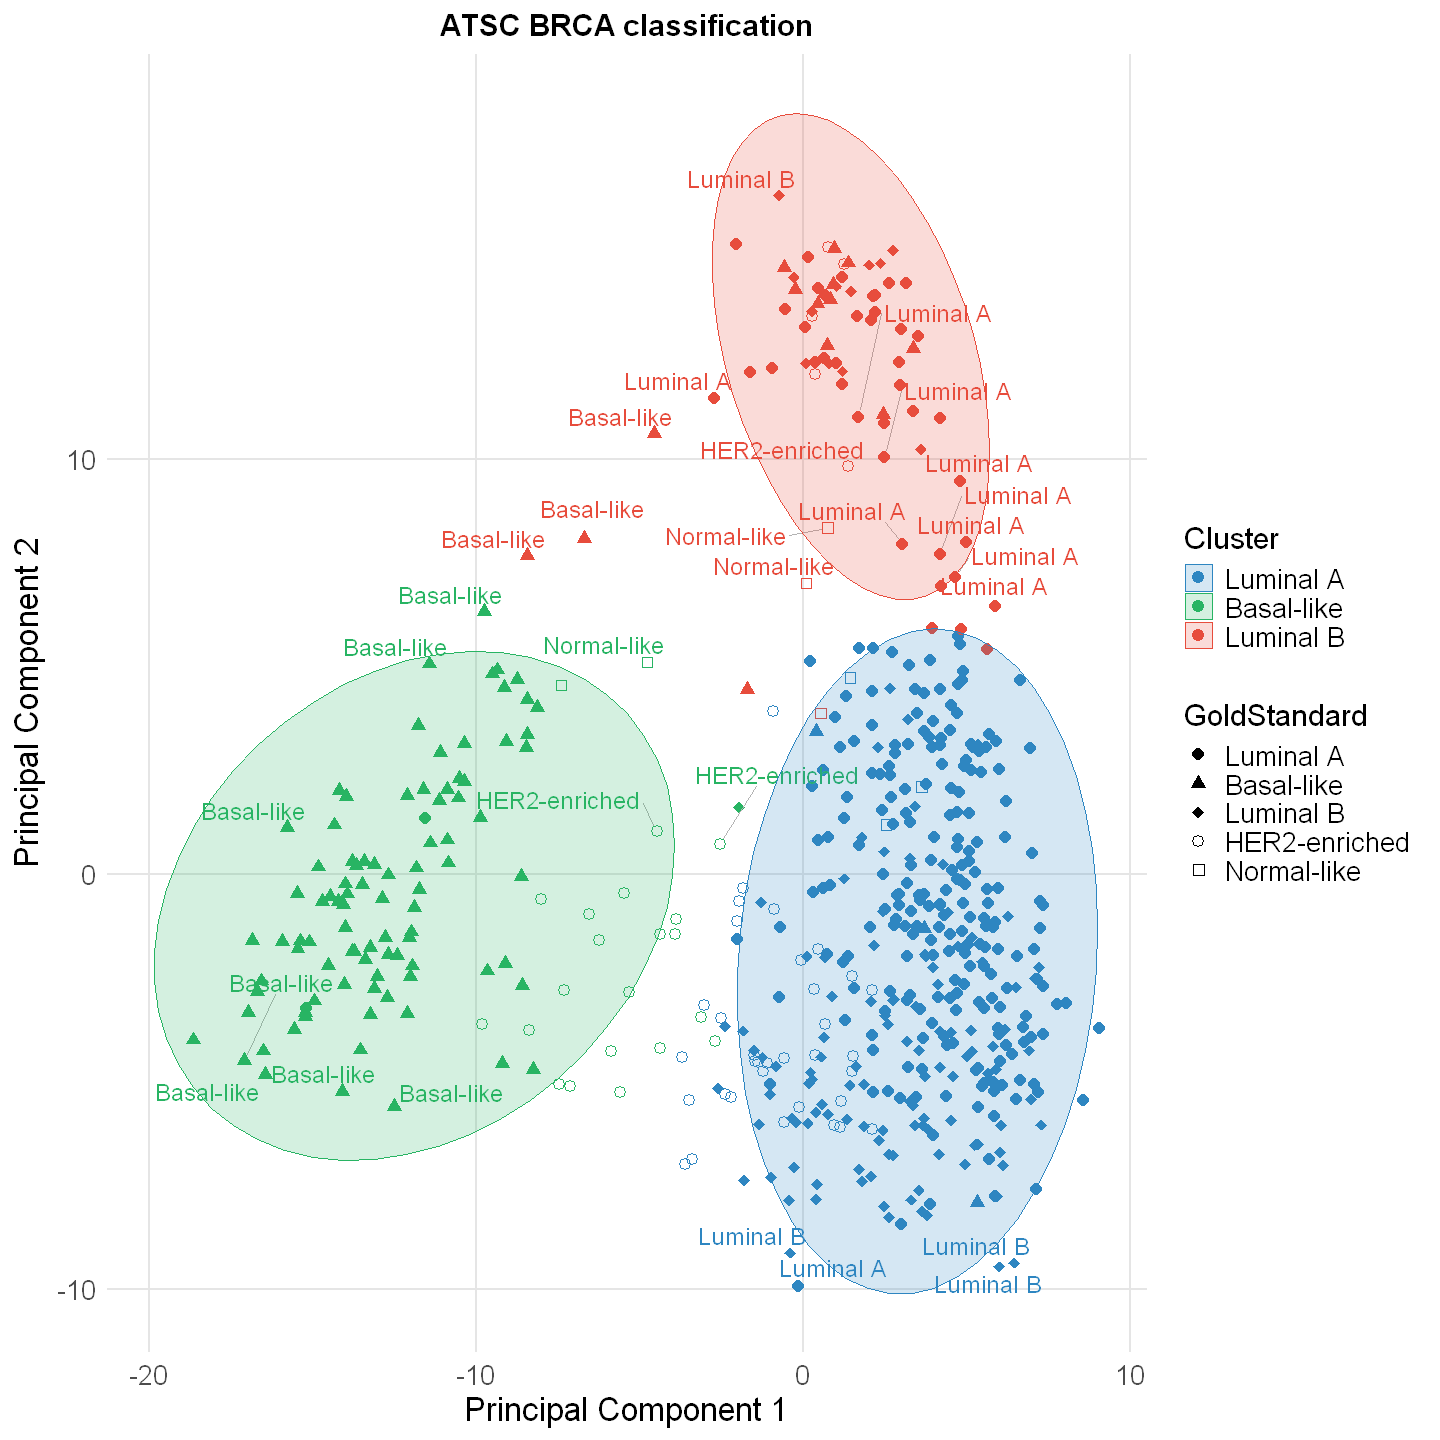

In [224]:
cluster_colors = c("#2E86C1", "#28B463", "#E74C3C", "#9B59B6", "#F1C40F", "#7F8C8D")

cluster_shapes = c(16, 17, 18, 21, 22)
cluster_labels = c("Luminal A", "Basal-like", "Luminal B", "HER2-enriched", "Normal-like")

ggplot(pca_df, aes(x = Dim.1, y = Dim.2, shape = GoldStandard, color = Cluster, label = Description)) +
  geom_point(size = 3) +
  geom_text_repel(
    vjust = 1,
    hjust = 1,
    size = 5,
    show.legend = FALSE,
    point.padding = 0.4,
    box.padding = 0.25,
    max.overlaps = 5,
    segment.color = "grey70",
    segment.size = 0.2
  ) +
  stat_ellipse(aes(fill = Cluster, group = Cluster), level = 0.95, alpha = 0.2, geom = "polygon") +
  labs(
    title = "ATSC BRCA classification",
    x = "Principal Component 1",
    y = "Principal Component 2"
  ) +
  scale_shape_manual(values = cluster_shapes, labels = unique(pca_df$Description)) +
  scale_color_manual(values = cluster_colors, labels = cluster_labels)  +
  scale_fill_manual(values = cluster_colors, labels = cluster_labels)   +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_blank()
  )

# Sensitivity <a class="anchor" id="sensitivity"></a>

In this Section we evaluate the sensitivity of our clustering using the `RSKC::Sensitivity` method. Sensitivity, or the true positive rate, measures the ability to correctly identify positive instances within the data. By focusing on sensitivity, we aim to ensure that our model effectively captures the relevant clusters, minimizing the number of false negatives. 

In [225]:
dataset["Class"] = dataset["Description"]
head(dataset)[, c("Description", "Class")]

,Description,Class
,<chr>,<chr>
TCGA-A1-A0SD-01,Luminal A,Luminal A
TCGA-A1-A0SE-01,Luminal A,Luminal A
TCGA-A1-A0SH-01,Luminal A,Luminal A
TCGA-A1-A0SJ-01,Luminal A,Luminal A
TCGA-A1-A0SK-01,Basal-like,Basal-like
TCGA-A1-A0SM-01,Luminal B,Luminal B


In [226]:
# Map categories with cluster number
dataset["Class_n"] = gold_standard_vector
# Table of prediction vs actual classification
head(dataset)[, c("Description", "Class", "Cluster", "Class_n")]

,Description,Class,Cluster,Class_n
,<chr>,<chr>,<fct>,<dbl>
TCGA-A1-A0SD-01,Luminal A,Luminal A,1,1
TCGA-A1-A0SE-01,Luminal A,Luminal A,1,1
TCGA-A1-A0SH-01,Luminal A,Luminal A,1,1
TCGA-A1-A0SJ-01,Luminal A,Luminal A,1,1
TCGA-A1-A0SK-01,Basal-like,Basal-like,2,2
TCGA-A1-A0SM-01,Luminal B,Luminal B,1,3


In [227]:
# Getting a vector of prediction vs actual classification
#actual = as.factor(as.vector(unlist(dataset["Class_n"])))
predicted <- as.numeric(as.vector(unlist(dataset["Cluster"])))

print("gold standard")
gold_standard_vector
print("predicted")
predicted

[1] "gold standard"


[1] 1 1 1 1 2 3 2 1 2 2 3 2 2 1 4 1 4 2 1 1 1 3 1 1 3 4 4 1 2 2 1 3 1 1 1 4 3
 [38] 1 1 1 1 1 3 2 1 3 3 2 1 2 4 2 3 3 1 1 1 1 1 2 1 3 3 1 2 5 1 2 1 2 2 1 1 1
 [75] 3 1 2 1 2 2 2 3 3 3 1 3 3 1 1 3 1 3 4 4 3 4 2 1 1 1 4 1 3 2 1 2 3 2 3 3 4
[112] 3 1 3 1 1 4 1 3 3 2 3 4 4 1 3 2 1 4 1 1 1 4 1 4 3 3 3 1 1 1 3 3 4 3 3 3 3
[149] 3 1 1 3 4 1 1 1 1 4 3 3 1 1 3 3 1 3 1 4 2 3 2 3 2 3 2 1 3 2 3 2 1 1 1 4 1
[186] 2 3 1 2 1 1 1 1 3 1 1 2 1 3 4 1 4 3 3 5 5 5 1 4 3 2 2 3 1 1 1 5 3 3 4 1 1
[223] 3 1 2 3 2 1 2 2 1 3 1 4 1 2 1 1 3 2 2 3 2 3 2 1 4 3 3 2 3 3 2 2 2 2 1 1 1
[260] 5 1 2 2 1 4 1 3 1 1 2 2 1 2 1 4 3 5 1 1 2 4 3 1 1 1 2 2 1 4 1 1 1 1 1 1 4
[297] 2 2 1 1 1 3 3 2 1 1 1 2 1 1 3 3 2 4 3 3 1 1 1 1 2 2 1 3 4 4 1 2 1 1 1 1 3
[334] 3 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 3 3 3 3 1 3 3 3 3 1 1 1 1 1 1 1 1
[371] 2 2 1 1 1 1 1 1 1 1 1 1 4 4 2 2 1 1 1 2 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1
[408] 1 1 1 1 1 2 1 1 1 3 1 4 2 3 1 1 1 2 3 2 1 1 3 3 2 2 3 3 1 1 1 1 4 4 2 2 4
[445] 4 1 1 1 3 3 2 2 2 1 1 1 1 1 1 1 4 4 3 3 2 2 2 4 1 1 4 4 4 2 3 3 1 4 2 1 2
[482] 4 4 4 4 3 1 3 3 3 4 3 1 2 2 1 2 1 1 3 5 3 3 1 3 1 1 2 3 4 1 2 3 1 4 3 2 2
[519] 1 2 4 1 1 1 3 1 2 2 2 3 3 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 1 1 1 3 3 2 4 1 1
[556] 2 1 1 1

[1] "predicted"


[1] 1 1 1 1 2 1 2 1 2 2 1 2 2 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 2 1
 [38] 3 1 1 3 1 1 2 1 1 1 2 1 2 2 2 1 1 1 1 1 1 1 2 1 1 1 1 2 3 1 2 1 3 2 1 3 1
 [75] 1 1 2 1 2 3 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 2 1 2 1 1 1
[112] 1 1 1 1 1 1 1 1 1 3 1 1 2 1 1 2 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1
[149] 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 1 2 1 2 1 2 1 1 2 1 2 1 1 1 1 1
[186] 2 1 1 2 3 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 2 1 2 2 1 1 1 1 3 2 1 1 1 1
[223] 1 1 2 1 2 1 2 2 1 1 1 2 3 2 1 1 1 2 2 1 2 1 2 1 1 1 1 2 1 1 2 2 2 2 1 1 1
[260] 2 1 2 2 1 1 1 1 1 1 2 2 1 2 1 1 1 1 1 1 2 1 1 1 1 1 2 2 1 1 1 1 1 1 1 3 2
[297] 2 3 1 1 1 1 1 2 1 1 1 2 1 1 3 1 2 2 3 1 3 1 1 1 3 2 1 1 3 1 1 2 3 1 3 1 1
[334] 1 2 3 1 2 3 3 3 1 3 1 1 3 1 3 1 3 1 3 2 3 1 3 1 1 3 1 1 1 1 3 1 3 1 1 3 1
[371] 3 2 3 3 3 1 3 1 1 3 1 1 3 1 3 2 3 1 1 2 1 3 3 1 1 1 1 1 1 3 1 1 3 1 1 3 1
[408] 1 1 1 3 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 2 1 1 3 1 3 1 3 1 3 1 3 1 3 1 3 3 3
[445] 1 3 1 2 3 1 3 2 2 1 1 1 3 1 3 1 3 1 3 1 3 2 2 2 1 1 2 1 1 2 1 1 1 1 2 1 2
[482] 2 1 1 1 1 1 1 1 1 2 1 1 2 2 1 2 1 1 1 3 1 1 1 1 1 1 2 1 2 1 2 1 1 1 1 2 2
[519] 1 2 1 3 1 1 1 1 3 2 2 1 1 1 1 1 3 1 1 1 3 1 1 3 1 1 3 1 1 1 1 1 1 2 2 1 1
[556] 1 2 1 1

In [228]:
sen = RSKC::Sensitivity(predicted, gold_standard_vector)
sensitivity_table <- sen$prob[1,]
names(sensitivity_table) = names(level_mapping[!grepl("K56|MCF", names(level_mapping))])
sensitivity_table
paste0("(", paste(unlist(sensitivity_table), collapse = ","), ")")

,Luminal A,Basal-like,Luminal B,HER2-enriched,Normal-like
,<chr>,<chr>,<chr>,<chr>,<chr>
Sensitivity. (%),84,84,90,58,38


[1] "(84,84,90,58,38)"

# CER <a class="anchor" id="cer"></a>
To assess the overall accuracy of our clustering, we compute the Classification Error Rate (CER) and compare it with the gold standard classification. CER represents the proportion of misclassified instances, thus providing a clear measure of the clustering performance in assigning individuals to the correct clusters.

In [229]:
cer = CER(predicted, gold_standard_vector)
cer = format(round(cer*100, 2), nsmall = 2)
print(paste0("CER: ", cer, "%"))

[1] "CER: 35.43%"


In [230]:
# CER: 35.43% - max_alpha = 0.1 - alpha (automatic) = 0.1 - L1 = 11.6299696326142 - kopt = 3
# CER: 0% - max_alpha = 0.25 - alpha (automatic) = null - L1 = 11.6299696326142 - kopt = -1

max_alpha
r_atsc$alpha
r_atsc$L1

[1] 0.1

[1] 0.05

[1] 11.62997